<a href="https://www.kaggle.com/code/mesutssmn/diabetes-analysis-and-ml?scriptVersionId=170260203" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix,mean_squared_error,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df = pd.read_csv("/kaggle/input/pima-indians-diabetes-database/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


# DATA ANALYSIS

In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [5]:
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
0            6      148             72             35        0 33.600   
1            1       85             66             29        0 26.600   
2            8      183             64              0        0 23.300   
3            1       89             66             23       94 28.100   
4            0      137             40             35      168 43.100   

   DiabetesPedigreeFunction  Age  Outcome  
0                    

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [8]:
cat_cols, num_cols, cat_but_car

(['Outcome'],
 ['Pregnancies',
  'Glucose',
  'BloodPressure',
  'SkinThickness',
  'Insulin',
  'BMI',
  'DiabetesPedigreeFunction',
  'Age'],
 [])

         Outcome  Ratio
Outcome                
0            500 65.104
1            268 34.896


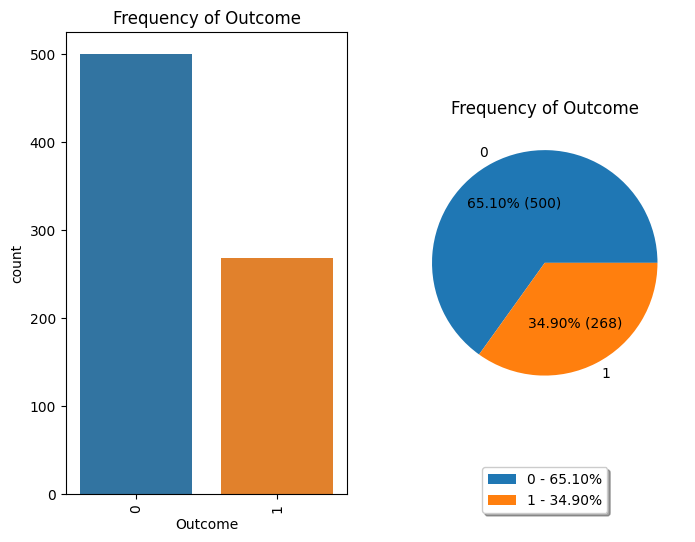

In [9]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(8, 6))
        plt.subplot(1, 2, 1)
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.title("Frequency of " + col_name)
        plt.xticks(rotation=90)

        plt.subplot(1, 2, 2)
        values = dataframe[col_name].value_counts()
        plt.pie(x=values, labels=values.index, autopct=lambda p: '{:.2f}% ({:.0f})'.format(p, p/100 * sum(values)))
        plt.title("Frequency of " + col_name)
        plt.legend(labels=['{} - {:.2f}%'.format(index, value/sum(values)*100) for index, value in zip(values.index, values)],
                   loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=1)
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, True)


count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


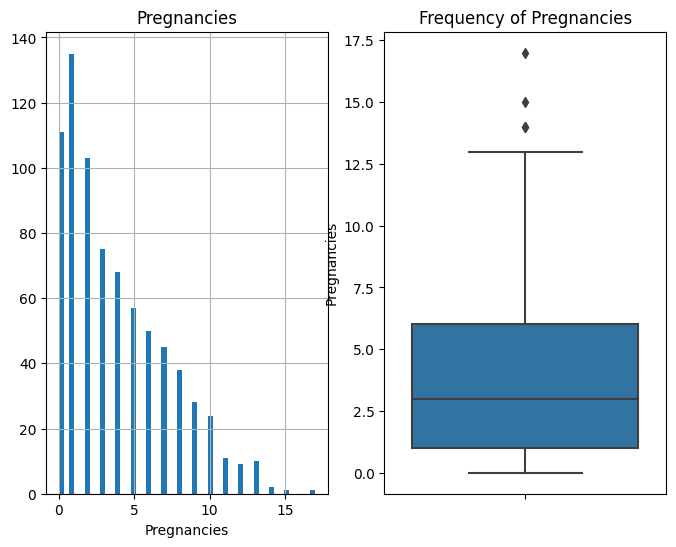

#####################################
count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


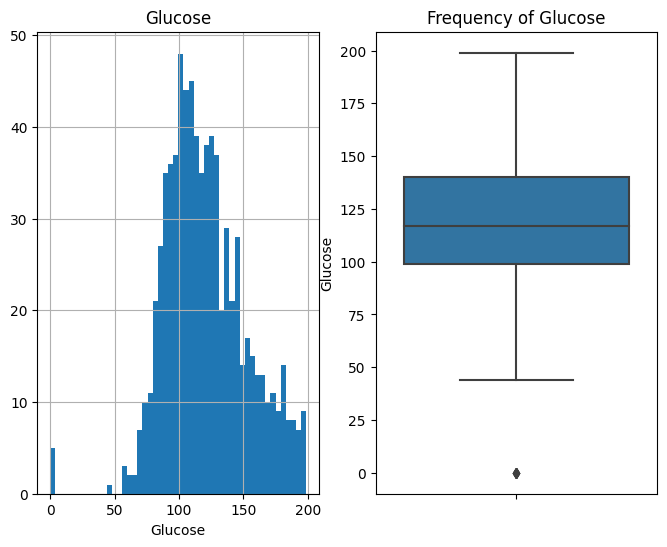

#####################################
count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64


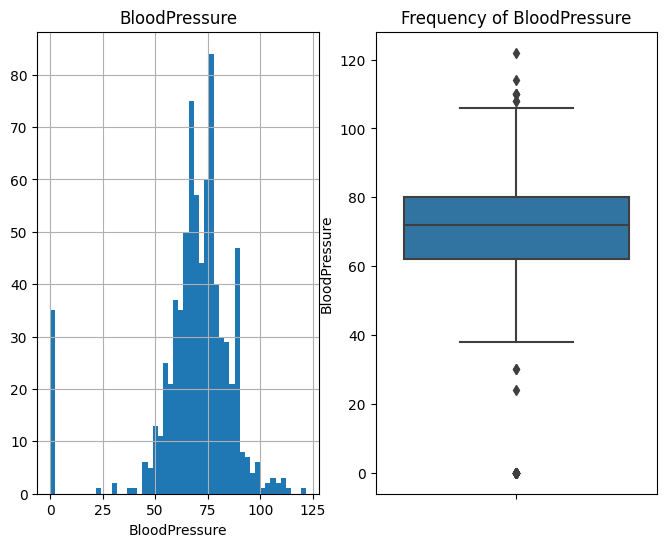

#####################################
count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


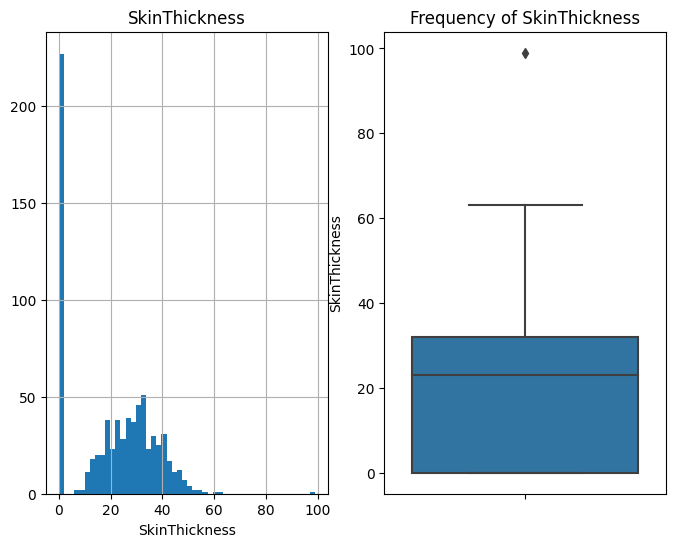

#####################################
count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
max     846.000
Name: Insulin, dtype: float64


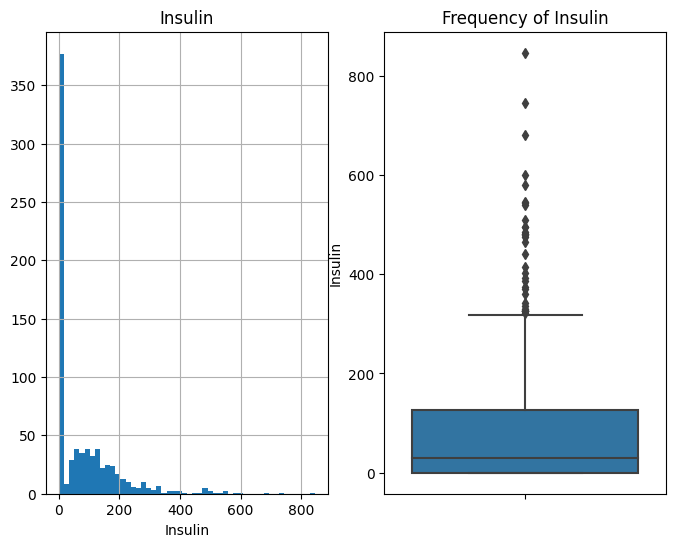

#####################################
count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


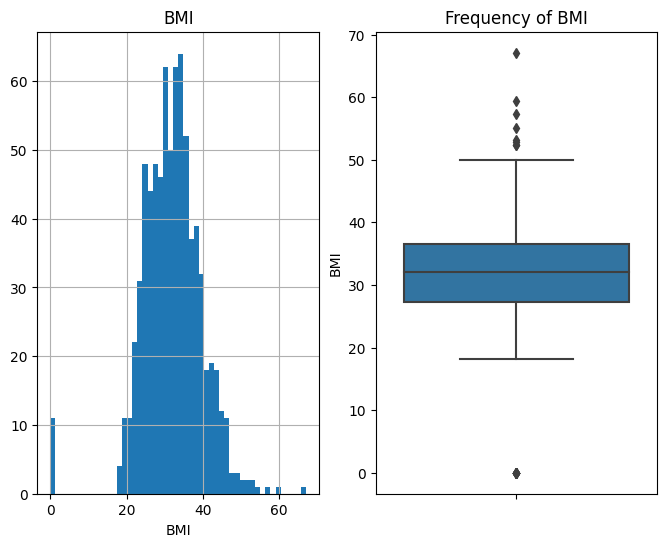

#####################################
count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


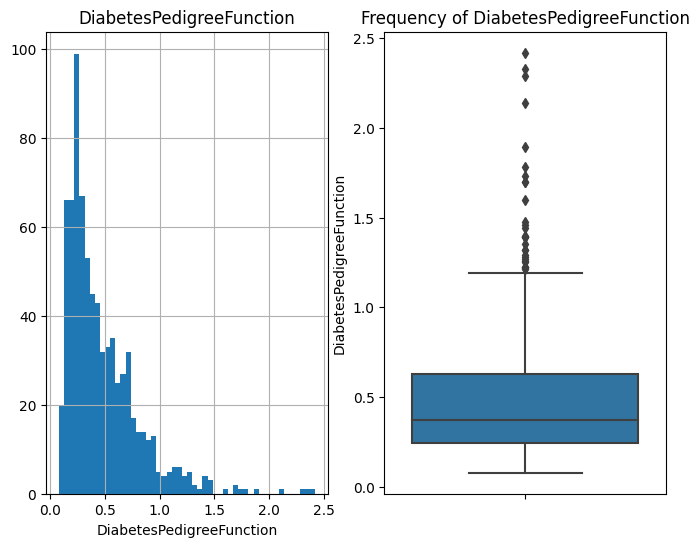

#####################################
count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: Age, dtype: float64


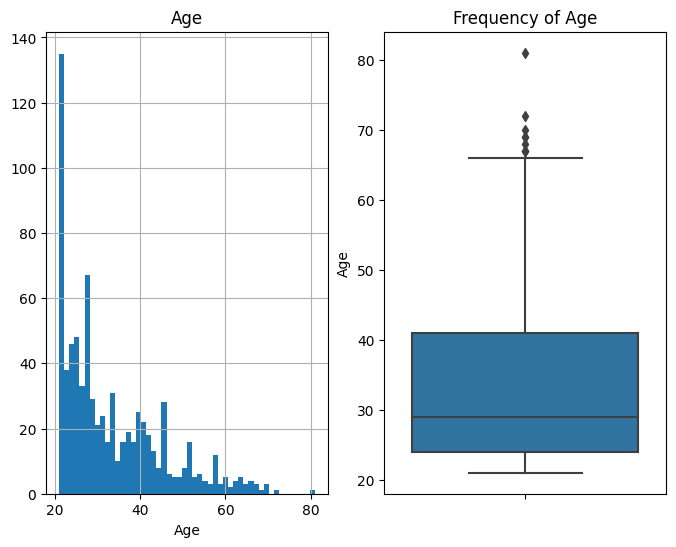

#####################################


In [10]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
            fig, axs = plt.subplots(1, 2, figsize=(8, 6))
            plt.subplot(1, 2, 1)
            dataframe[numerical_col].hist(bins=50)
            plt.xlabel(numerical_col)
            plt.title(numerical_col)

            plt.subplot(1, 2, 2)
            sns.boxplot(y=numerical_col, data=dataframe)
            plt.title("Frequency of " + numerical_col)
            plt.xticks(rotation=90)

            plt.show(block=True)      

    print("#####################################")

for col in num_cols:
    num_summary(df, col, plot=True)

In [11]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




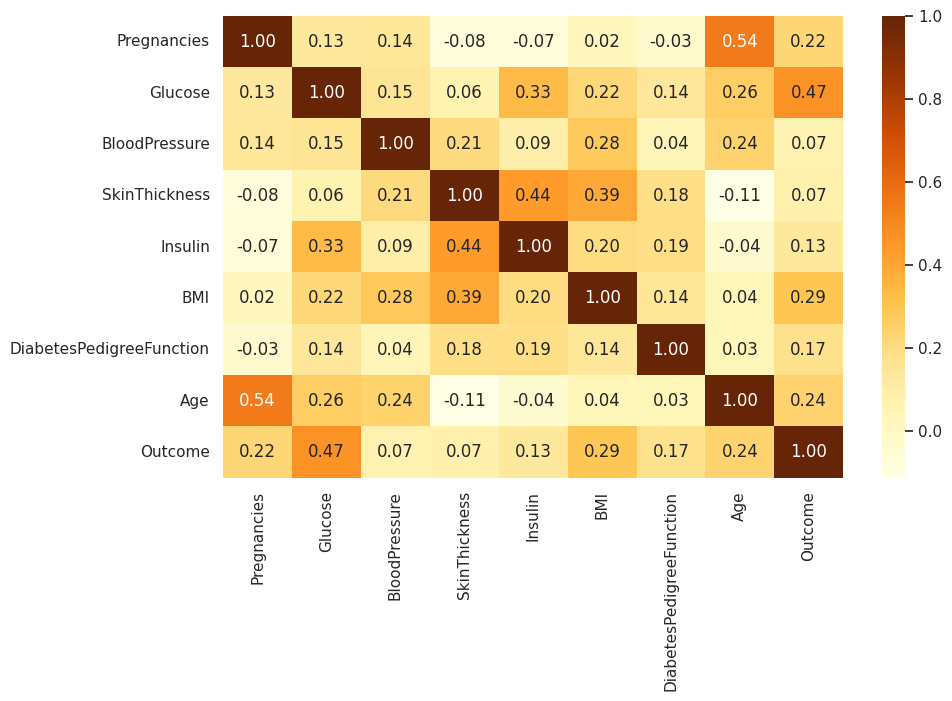

In [12]:
corr = df.corr()
sns.set(rc={'figure.figsize': (10, 6)})
sns.heatmap(corr, cmap="YlOrBr", annot=True, fmt=".2f")
plt.show()

In [13]:
y = df["Outcome"]
X = df.drop("Outcome", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

rf_model = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [14]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.73
Recall: 0.625
Precision: 0.65
F1: 0.64
Auc: 0.71


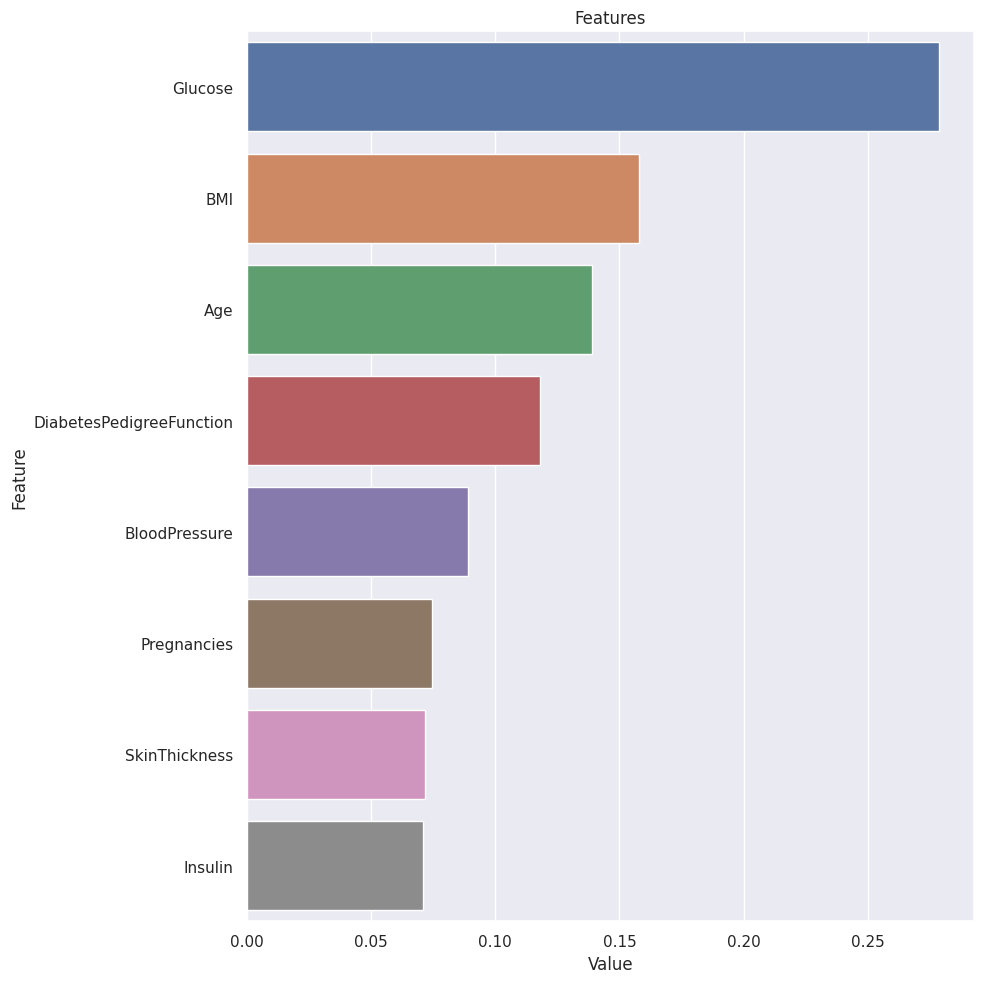

In [15]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)

In [16]:
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]

zero_columns

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [17]:
for col in zero_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col])

In [18]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [19]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

na_columns = missing_values_table(df, na_name=True)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


In [20]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


missing_vs_target(df, "Outcome", na_columns)


                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                      0.349    763
1                      0.400      5


                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                            0.344    733
1                            0.457     35


                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                            0.333    541
1                            0.388    227


                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                      0.330    394
1                      0.369    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11




In [21]:
for col in zero_columns:
    df.loc[df[col].isnull(), col] = df[col].median()


df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [22]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [23]:
for col in df.columns:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [24]:
for col in df.columns:
    print(col, check_outlier(df, col))


Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [25]:
df.loc[(df["Age"] >= 21) & (df["Age"] < 50), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 50), "NEW_AGE_CAT"] = "senior"

In [26]:
df['NEW_BMI'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100],labels=["Underweight", "Healthy", "Overweight", "Obese"])
df["NEW_GLUCOSE"] = pd.cut(x=df["Glucose"], bins=[0, 140, 200, 300], labels=["Normal", "Prediabetes", "Diabetes"])

In [27]:
df.loc[(df["BMI"] < 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "underweightmature"
df.loc[(df["BMI"] < 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "underweightsenior"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "healthymature"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "healthysenior"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "overweightmature"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "overweightsenior"
df.loc[(df["BMI"] > 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "obesemature"
df.loc[(df["BMI"] > 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "obesesenior"

In [28]:
df.loc[(df["Glucose"] < 70) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "lowmature"
df.loc[(df["Glucose"] < 70) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "lowsenior"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "normalmature"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "normalsenior"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "hiddenmature"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "hiddensenior"
df.loc[(df["Glucose"] > 125) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "highmature"
df.loc[(df["Glucose"] > 125) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "highsenior"

In [29]:
def set_insulin(dataframe, col_name="Insulin"):
    if 16 <= dataframe[col_name] <= 166:
        return "Normal"
    else:
        return "Abnormal"


In [30]:
df["NEW_INSULIN_SCORE"] = df.apply(set_insulin, axis=1)

df["NEW_GLUCOSE*INSULIN"] = df["Glucose"] * df["Insulin"]

df["NEW_GLUCOSE*PREGNANCIES"] = df["Glucose"] * df["Pregnancies"]

In [31]:
df.columns = [col.upper() for col in df.columns]

df.head()


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,Obese,Prediabetes,obesesenior,highsenior,Normal,18500.000,888.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,Overweight,Normal,obesemature,normalmature,Normal,10625.000,85.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,Healthy,Prediabetes,obesemature,highmature,Normal,22875.000,1464.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight,Normal,obesemature,normalmature,Normal,8366.000,89.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese,Normal,obesemature,highmature,Abnormal,23016.000,0.000


In [32]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)


Observations: 768
Variables: 17
cat_cols: 7
num_cols: 10
cat_but_car: 0
num_but_cat: 3


In [33]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

['NEW_AGE_CAT', 'NEW_INSULIN_SCORE']

In [34]:
for col in binary_cols:
    df = label_encoder(df, col)

In [35]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["OUTCOME"]]
cat_cols

['NEW_AGE_BMI_NOM', 'NEW_AGE_GLUCOSE_NOM', 'NEW_BMI', 'NEW_GLUCOSE']

In [36]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,1,1,18500.000,888.000,True,False,False,False,True,False,False,False,False,False,False,True,True,False
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,0,1,10625.000,85.000,False,False,False,False,False,False,False,True,False,False,True,False,False,False
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,0,1,22875.000,1464.000,False,False,False,True,False,False,False,False,False,True,False,False,True,False
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,0,1,8366.000,89.000,False,False,False,False,False,False,False,True,False,False,True,False,False,False
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,0,23016.000,0.000,False,False,False,True,False,False,False,False,False,False,False,True,False,False


In [37]:
num_cols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE',
 'NEW_GLUCOSE*INSULIN',
 'NEW_GLUCOSE*PREGNANCIES']

In [38]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,0.640,0.866,-0.032,0.680,-0.183,0.167,0.468,1.426,1,1,1,0.024,0.882,True,False,False,False,True,False,False,False,False,False,False,True,True,False
1,-0.845,-1.205,-0.528,-0.011,-0.183,-0.852,-0.365,-0.191,0,0,1,-0.503,-0.858,False,False,False,False,False,False,False,True,False,False,True,False,False,False
2,1.234,2.017,-0.694,-0.011,-0.183,-1.333,0.604,-0.106,1,0,1,0.317,2.129,False,False,False,True,False,False,False,False,False,True,False,False,True,False
3,-0.845,-1.074,-0.528,-0.702,-0.553,-0.634,-0.921,-1.042,0,0,1,-0.654,-0.849,False,False,False,False,False,False,False,True,False,False,True,False,False,False
4,-1.142,0.504,-2.679,0.680,0.331,1.549,5.485,-0.020,1,0,0,0.326,-1.042,False,False,False,True,False,False,False,False,False,False,False,True,False,False


In [39]:
for i in df.columns:
    if df[i].dtype == bool:  
        df[i] = df[i].astype(int) 

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   PREGNANCIES                        768 non-null    float64
 1   GLUCOSE                            768 non-null    float64
 2   BLOODPRESSURE                      768 non-null    float64
 3   SKINTHICKNESS                      768 non-null    float64
 4   INSULIN                            768 non-null    float64
 5   BMI                                768 non-null    float64
 6   DIABETESPEDIGREEFUNCTION           768 non-null    float64
 7   AGE                                768 non-null    float64
 8   OUTCOME                            768 non-null    int64  
 9   NEW_AGE_CAT                        768 non-null    int64  
 10  NEW_INSULIN_SCORE                  768 non-null    int64  
 11  NEW_GLUCOSE*INSULIN                768 non-null    float64

In [41]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,0.640,0.866,-0.032,0.680,-0.183,0.167,0.468,1.426,1,1,1,0.024,0.882,1,0,0,0,1,0,0,0,0,0,0,1,1,0
1,-0.845,-1.205,-0.528,-0.011,-0.183,-0.852,-0.365,-0.191,0,0,1,-0.503,-0.858,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,1.234,2.017,-0.694,-0.011,-0.183,-1.333,0.604,-0.106,1,0,1,0.317,2.129,0,0,0,1,0,0,0,0,0,1,0,0,1,0
3,-0.845,-1.074,-0.528,-0.702,-0.553,-0.634,-0.921,-1.042,0,0,1,-0.654,-0.849,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,-1.142,0.504,-2.679,0.680,0.331,1.549,5.485,-0.020,1,0,0,0.326,-1.042,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [42]:
y = df["OUTCOME"]
X = df.drop("OUTCOME", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [43]:
unique, counts = np.unique(y_test, return_counts=True)
for value, count in zip(unique, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0, Count: 150
Value: 1, Count: 81


# MACHINE LEARNING MODELS

In [44]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.79
Recall: 0.711
Precision: 0.67
F1: 0.69
Auc: 0.77


    Value                            Feature
1   0.138                            GLUCOSE
10  0.131                NEW_GLUCOSE*INSULIN
5   0.099                                BMI
11  0.098            NEW_GLUCOSE*PREGNANCIES
7   0.097                                AGE
..    ...                                ...
20  0.001   NEW_AGE_GLUCOSE_NOM_normalsenior
17  0.000      NEW_AGE_GLUCOSE_NOM_lowmature
13  0.000  NEW_AGE_BMI_NOM_underweightmature
18  0.000      NEW_AGE_GLUCOSE_NOM_lowsenior
25  0.000               NEW_GLUCOSE_Diabetes

[26 rows x 2 columns]


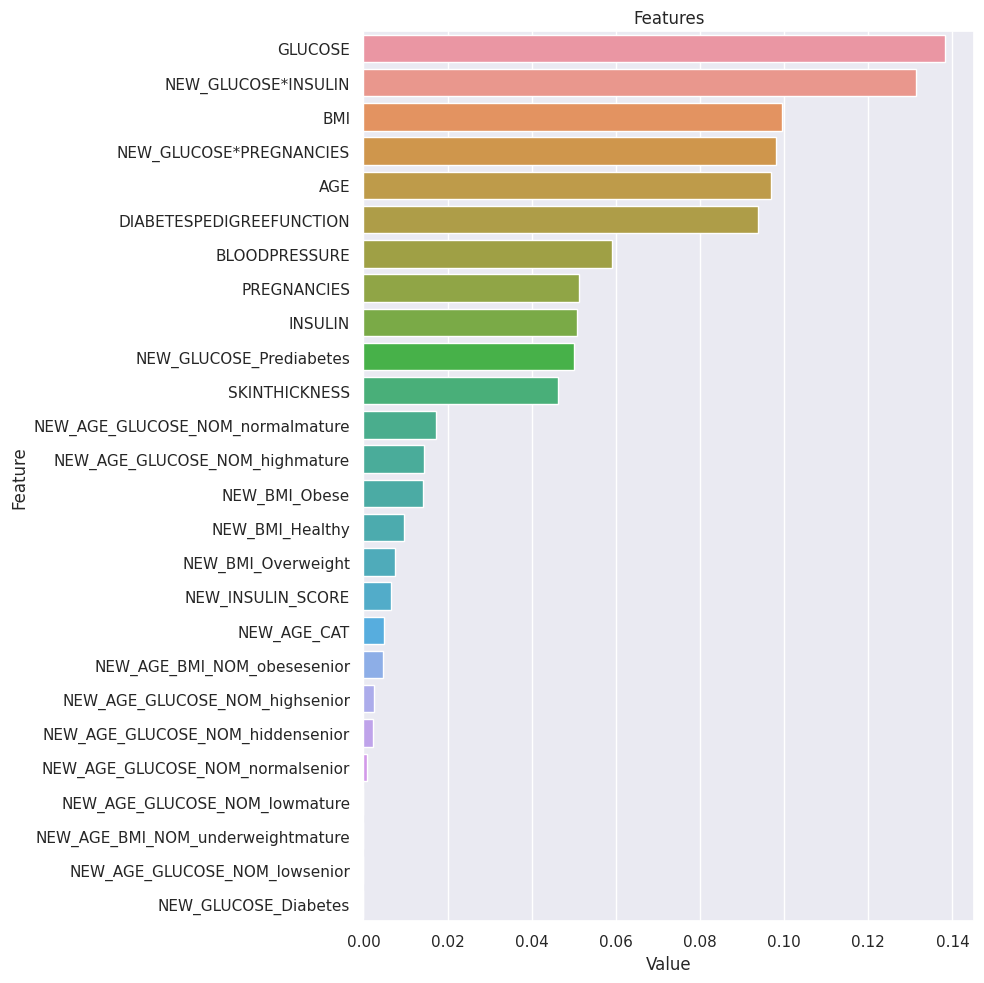

In [45]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)

In [46]:
models = [('LR', LogisticRegression()),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier()),
          ('RF', RandomForestClassifier(n_estimators=200)),
          ('SVC', SVC()),
          ('GBM', GradientBoostingClassifier(n_estimators=200, learning_rate=0.06)),
          ("XGBoost", XGBClassifier(learning_rate=0.06)),
          ("LightGBM", LGBMClassifier(learning_rate=0.06, verbose=-1)),
          ("CatBoost", CatBoostClassifier(learning_rate=0.06,verbose=False))]

In [47]:
acclist=[]
for name, model in models:
    acc = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy"))
    acclist.append([name,acc])
    print(f"ACC: {round(acc, 4)} ({name}) ")

ACC: 0.7654 (LR) 
ACC: 0.719 (KNN) 
ACC: 0.7021 (CART) 
ACC: 0.7543 (RF) 
ACC: 0.7599 (SVC) 
ACC: 0.7692 (GBM) 
ACC: 0.7563 (XGBoost) 
ACC: 0.7562 (LightGBM) 
ACC: 0.7488 (CatBoost) 


In [48]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

gbc_accuracy=round(accuracy_score(y_test,y_pred), 4)*100
gbc_accuracy

76.62

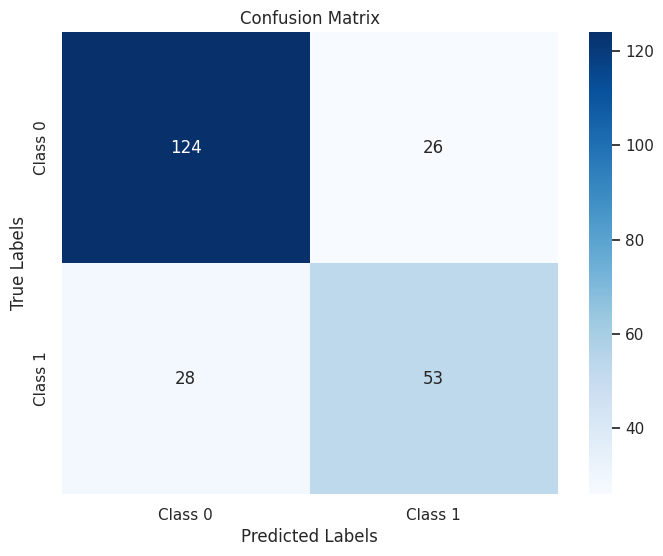

In [49]:
cm = confusion_matrix(y_test, y_pred)

class_labels = ['Class 0', 'Class 1']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [50]:
xgb = XGBClassifier(learning_rate = 0.05)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

xgb_accuracy=round(accuracy_score(y_test,y_pred), 4)*100
xgb_accuracy

78.35

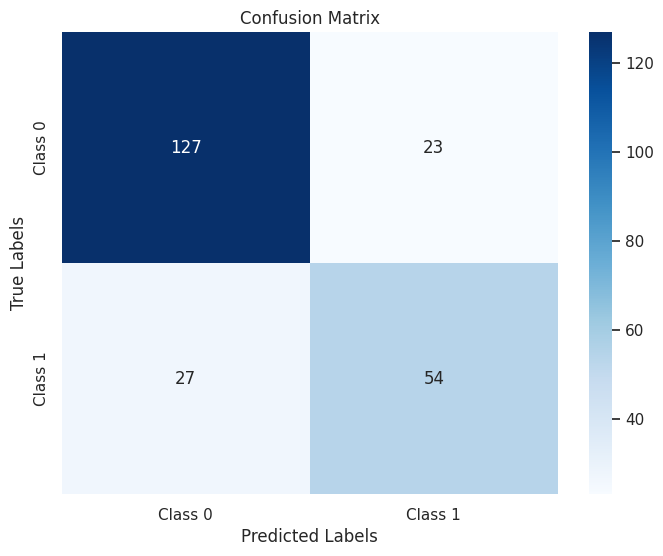

In [51]:
cm = confusion_matrix(y_test, y_pred)

class_labels = ['Class 0', 'Class 1']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [52]:
lgb_model = LGBMClassifier(verbose=-1, random_state=42)
lgb_params = {"learning_rate": [0.01, 0.02, 0.03,0.04, 0.06, 0.08, 0.1],
               "n_estimators": [300, 400, 600, 1200, 1500]}
lgb_gs_best = GridSearchCV(lgb_model,
                            lgb_params,
                            cv=3,
                            n_jobs=-1,
                            verbose=False).fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current versio

In [53]:
lgb_gs_best.best_params_

{'learning_rate': 0.01, 'n_estimators': 400}

In [54]:
final_model = lgb_model.set_params(**lgb_gs_best.best_params_).fit(X_train, y_train)

In [55]:
final_model.score(X_test,y_test)

0.7748917748917749

In [56]:

prediction= final_model.predict(X_test)
prediction

array([0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

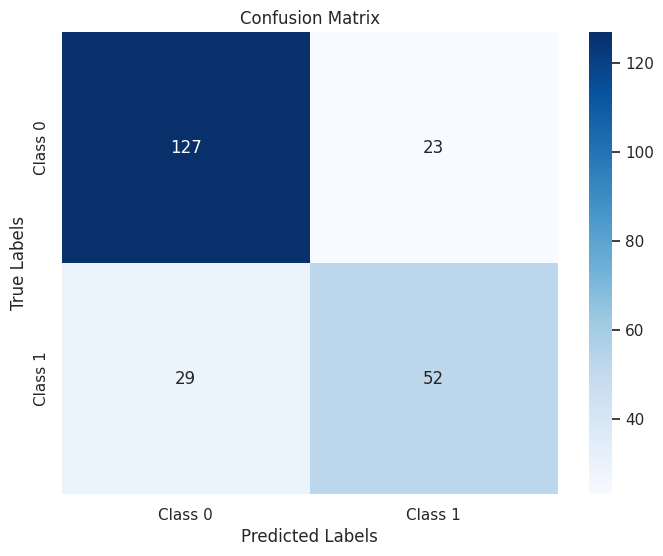

In [57]:
cm = confusion_matrix(y_test, prediction)

# Define class labels
class_labels = ['Class 0', 'Class 1']

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# DEEP LEARNING MODELS

In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization

2024-04-04 10:01:30.171218: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 10:01:30.171341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 10:01:30.303846: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [59]:
X_train.shape[1]

26

In [60]:
model = tf.keras.Sequential()
input_layer = tf.keras.layers.Dense(16, input_shape=(X_train.shape[1],), activation="relu")
model.add(input_layer)

model.add(tf.keras.layers.Dense(8, activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(8, activation="elu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(4, activation="elu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,033 (4.04 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 72 (288.00 B)

In [61]:
history = model.fit(X_train, y_train,
                    callbacks=[early_stopping],
                    epochs=100, verbose=1, batch_size=100, validation_split=0.2)

Epoch 1/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 47s 12s/step - accuracy: 0.5400 - loss: 0.7158

I0000 00:00:1712224912.807190     159 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5187 - loss: 0.7400 - val_accuracy: 0.3796 - val_loss: 0.7042
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5445 - loss: 0.7200 - val_accuracy: 0.5648 - val_loss: 0.6959
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5779 - loss: 0.6946 - val_accuracy: 0.6667 - val_loss: 0.6890
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5789 - loss: 0.7047 - val_accuracy: 0.6944 - val_loss: 0.6821
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5499 - loss: 0.7054 - val_accuracy: 0.6759 - val_loss: 0.6759
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5838 - loss: 0.7174 - val_accuracy: 0.6667 - val_loss: 0.6704
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5462 - loss: 0.7146 - val_accuracy: 0.6759 - val_loss: 0.6649
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5959 - loss: 0.6787 - val_accuracy: 0.6759 - val_loss: 0.6602
Epoch

In [62]:
loss_and_metrics = model.evaluate(X_test, y_test)
print(loss_and_metrics)
print('Loss = ',loss_and_metrics[0])
print('Accuracy = ',loss_and_metrics[1])

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8148 - loss: 0.4813
[0.4981785714626312, 0.7835497856140137]
Loss =  0.4981785714626312
Accuracy =  0.7835497856140137


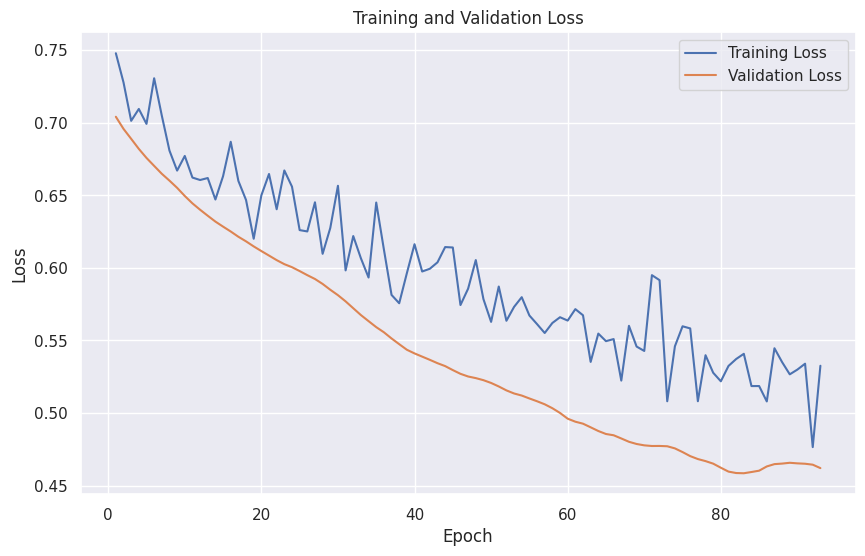

In [63]:
plt.figure(figsize=(10, 6))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [64]:
predicted = model.predict(X_test)
predicted = tf.squeeze(predicted)
predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
actual = np.array(y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


In [65]:
predicted

array([0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

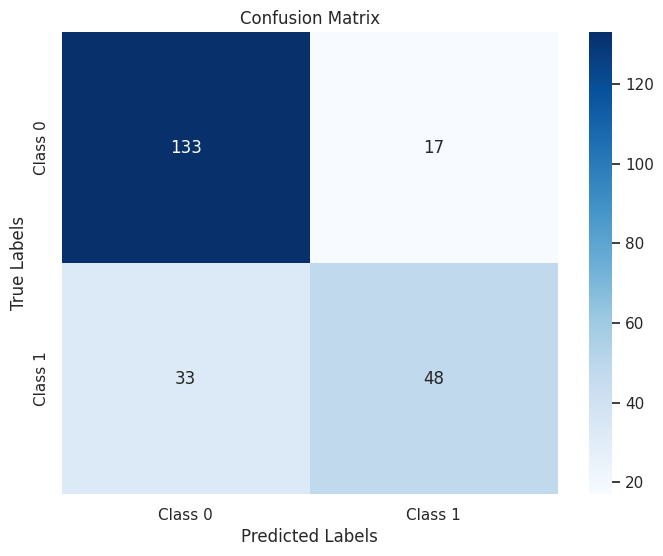

In [66]:
cm = confusion_matrix(y_test, predicted)

# Define class labels
class_labels = ['Class 0', 'Class 1']

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

In [68]:
model = Sequential([
    Conv1D(32, kernel_size=2, activation='relu', input_shape=(26,1)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.4),

    Conv1D(64, kernel_size=2, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.3),

    
    Conv1D(64, kernel_size=1, activation='elu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    
    Conv1D(32, kernel_size=1, activation='elu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    
    Flatten(),
    
    Dense(16, activation='relu'),
    Dropout(0.5),
    
    Dense(8, activation='elu'),
    Dropout(0.5),
    
    Dense(1, activation='sigmoid') 
])

In [69]:
from keras.optimizers import SGD

model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.99), 
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 25, 32)         │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 6, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 6, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 3, 32)          │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,937 (46.63 KB)

 Trainable params: 11,553 (45.13 KB)

 Non-trainable params: 384 (1.50 KB)

In [70]:
history = model.fit(X_train, y_train,
                    callbacks=[early_stopping],
                    epochs=200, verbose=1, batch_size=32, validation_split=0.2)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 720ms/step - accuracy: 0.5586 - loss: 0.7931 - val_accuracy: 0.7407 - val_loss: 0.6839
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5536 - loss: 0.7294 - val_accuracy: 0.7130 - val_loss: 0.6641
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5495 - loss: 0.7137 - val_accuracy: 0.7037 - val_loss: 0.6470
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6177 - loss: 0.6395 - val_accuracy: 0.6852 - val_loss: 0.6359
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6300 - loss: 0.5841 - val_accuracy: 0.6667 - val_loss: 0.6300
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6898 - loss: 0.5826 - val_accuracy: 0.6667 - val_loss: 0.6280
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7185 - loss: 0.5649 - val_accuracy: 0.6759 - val_loss: 0.6287
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6735 - loss: 0.5698 - val_accuracy: 0.6759 

In [71]:
loss_and_metrics = model.evaluate(X_test, y_test)
print(loss_and_metrics)
print('Loss = ',loss_and_metrics[0])
print('Accuracy = ',loss_and_metrics[1])

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.7115 - loss: 0.5118
[0.5032860040664673, 0.7186146974563599]
Loss =  0.5032860040664673
Accuracy =  0.7186146974563599


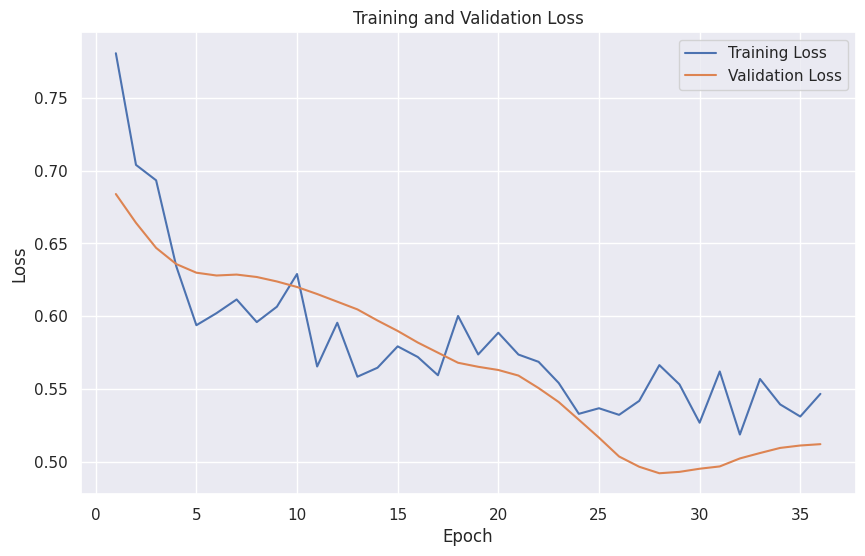

In [72]:
plt.figure(figsize=(10, 6))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [73]:
predicted = model.predict(X_test)
predicted = tf.squeeze(predicted)
predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
actual = np.array(y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


In [74]:
predicted

array([0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0])

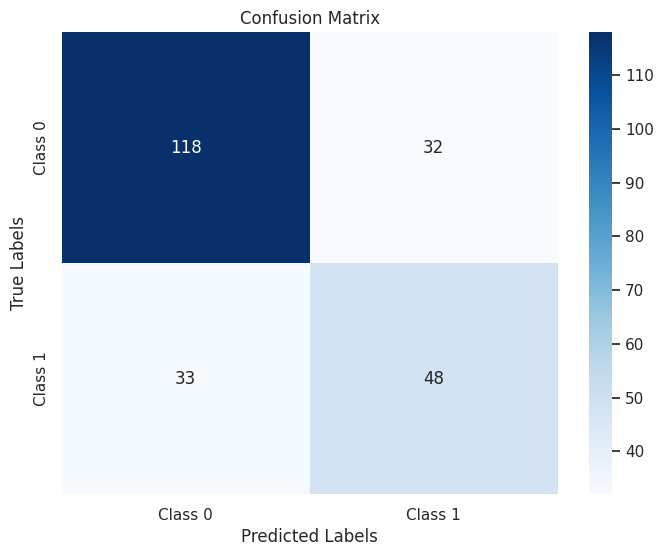

In [75]:
cm = confusion_matrix(y_test, predicted)

# Define class labels
class_labels = ['Class 0', 'Class 1']

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [76]:
from keras.layers import LSTM
from keras.optimizers import RMSprop
model = Sequential([
    LSTM(64, activation='relu', input_shape=(26, 1), return_sequences=True),
    LSTM(64, activation='relu'),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=0.001), 
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 26, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
history = model.fit(X_train, y_train,
                    callbacks=[early_stopping],
                    epochs=200, verbose=1, batch_size=15, validation_split=0.2)

Epoch 1/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.6592 - loss: 0.6726 - val_accuracy: 0.6759 - val_loss: 0.5179
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6502 - loss: 0.5660 - val_accuracy: 0.6759 - val_loss: 0.5072
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7118 - loss: 0.5322 - val_accuracy: 0.7315 - val_loss: 0.5760
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7333 - loss: 0.5360 - val_accuracy: 0.7130 - val_loss: 0.4998
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7034 - loss: 0.5580 - val_accuracy: 0.7222 - val_loss: 0.5003
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7286 - loss: 0.5298 - val_accuracy: 0.7130 - val_loss: 0.4898
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7476 - loss: 0.5012 - val_accuracy: 0.6667 - val_loss: 0.5874
Epoch 8/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7011 - loss: 0.5465 - val_accuracy: 0.7407 

In [78]:
loss_and_metrics = model.evaluate(X_test, y_test)
print(loss_and_metrics)
print('Loss = ',loss_and_metrics[0])
print('Accuracy = ',loss_and_metrics[1])

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.7198 - loss: 0.5216
[0.5011480450630188, 0.7316017150878906]
Loss =  0.5011480450630188
Accuracy =  0.7316017150878906


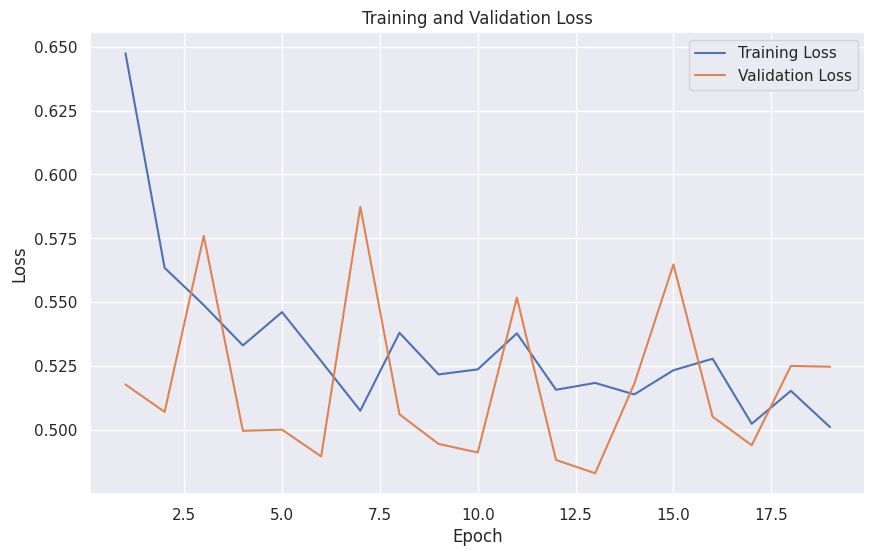

In [79]:
plt.figure(figsize=(10, 6))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [80]:
predicted = model.predict(X_test)
predicted = tf.squeeze(predicted)
predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
actual = np.array(y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


In [81]:
predicted

array([0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0])

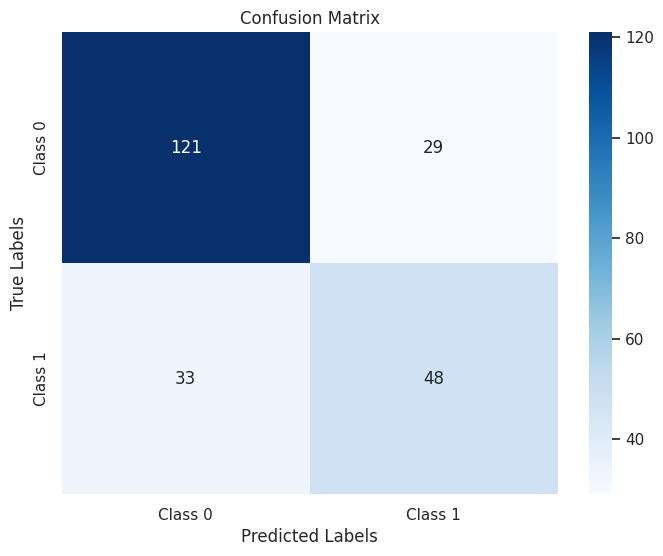

In [82]:
cm = confusion_matrix(y_test, predicted)

# Define class labels
class_labels = ['Class 0', 'Class 1']

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()